In [1]:
## Standard Imports ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Web Scraping Tools

In [2]:
from bs4 import BeautifulSoup
import requests
import time
import random
import re

In [101]:
import pickle

Read in Movie Plots Dataset from Kaggle:  
https://www.kaggle.com/jrobischon/wikipedia-movie-plots/data

In [3]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
df.replace(['Unknown','unknown'], np.nan, inplace=True)

In [5]:
type(df['Wiki Page'][0])

str

# EDA

In [6]:
df['Plot'][[0,1,2]]

0    A bartender is working at a saloon, serving dr...
1    The moon, painted with a smiling face hangs ov...
2    The film, just over a minute long, is composed...
Name: Plot, dtype: object

In [7]:
df['Wiki Page'][0]

'https://en.wikipedia.org/wiki/Kansas_Saloon_Smashers'

## How many movies per year?

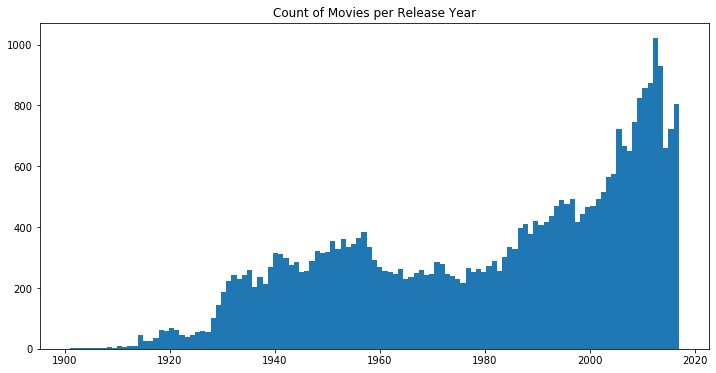

In [8]:
plt.figure(figsize=(12,6))
plt.title("Count of Movies per Release Year")
plt.hist(df['Release Year'], bins=len(set(df['Release Year'])));

## How many movies with missing data?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
Release Year        34886 non-null int64
Title               34884 non-null object
Origin/Ethnicity    34886 non-null object
Director            33762 non-null object
Cast                33463 non-null object
Genre               28803 non-null object
Wiki Page           34886 non-null object
Plot                34886 non-null object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


## How to find the unique info for each movie

In [10]:
df['Director'].nunique()

12592

In [11]:
df['Genre'].nunique()

2264

In [12]:
df['Title'].nunique()

32431

In [13]:
df.groupby(['Release Year','Title']).nunique()

Release Year  Title  \
Release Year Title                                                   
1901         Kansas Saloon Smashers                       1      1   
             Love by the Light of the Moon                1      1   
             Terrible Teddy, the Grizzly King             1      1   
             The Martyred Presidents                      1      1   
1902         Jack and the Beanstalk                       1      1   
...                                                     ...    ...   
2017         Zhalla Bobhata                               1      1   
             iBoy                                         1      1   
             xXx: Return of Xander Cage                   1      1   
             Çalgı Çengi İkimiz                           1      1   
             İstanbul Kırmızısı                           1      1   

                                               Origin/Ethnicity  Director  \
Release Year Title                                                          
1901         Kansas Saloon Smashers                           1         0   
             Love by the Light of the Moon                    1         0   
             Terrible Teddy, the Grizzly King                 1         0   
             The Martyred Presidents                          1         0   
1902         Jack and the Beanstalk                           1         1   
...                                                         ...       ...   
2017         Zhalla Bobhata                                   1         1   
             iBoy                                             2         2   
             xXx: Return of Xander Cage                       1         1   
             Çalgı Çengi İkimiz                               1         1   
             İstanbul Kırmızısı                               1         1   

                                               Cast  Genre  Wiki Page  Plot  
Release Year Title                                                           
1901         Kansas Saloon Smashers               0      0          1     1  
             Love by the Light of the Moon        0      0          1     1  
             Terrible Teddy, the Grizzly King     0      0          1     1  
             The Martyred Presidents              0      0          1     1  
1902         Jack and the Beanstalk               0      0          1     1  
...                                             ...    ...        ...   ...  
2017         Zhalla Bobhata                       1      1          1     1  
             iBoy                                 2      1          1     1  
             xXx: Return of Xander Cage           1      1          1     1  
             Çalgı Çengi İkimiz                   1      1          1     1  
             İstanbul Kırmızısı                   1      1          1     1  

[34607 rows x 8 columns]

In [14]:
df[df['Title']=='iBoy']

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
17177,2017,iBoy,American,Adam Randall,"Adam Randall (director), Joe Barton (screenpla...","action, crime",https://en.wikipedia.org/wiki/IBoy,"Living in a gang ridden part of London, teenag..."
21657,2017,iBoy,British,Director: Adam Randall,"Director: Adam Randall\r\nCast: Bill Milner, M...",NaN,https://en.wikipedia.org/wiki/IBoy,"Living in a gang ridden part of London, teenag..."


In [15]:
df['Wiki Page'].nunique()

34070

In [16]:
random.sample(list(df['Wiki Page']), 3)

['https://en.wikipedia.org/wiki/Life_(1999_film)',
 'https://en.wikipedia.org/wiki/Sundara_Purushan_(1996_film)',
 'https://en.wikipedia.org/wiki/The_Company_(film)']

# Scrape List of Cult Films from Wikipedia

Start with "requests" to see the important information.  

## Scrape https://en.wikipedia.org/wiki/List_of_cult_films for list of pages to scrape.

In [18]:
url_1 = 'https://en.wikipedia.org/wiki/List_of_cult_films'
response_1 = requests.get(url_1)

In [19]:
page_1 = response_1.text

In [20]:
soup_1 = BeautifulSoup(page_1, "lxml")

In [21]:
print(soup_1.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of cult films - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XdgKmgpAIC0AAIDCjqoAAABF","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_cult_films","wgTitle":"List of cult films","wgCurRevisionId":927421855,"wgRevisionId":927421855,"wgArticleId":34301706,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Use dmy dates fr

In [22]:
soup_1.find('a', href=re.compile('^/wiki/List_of_cult_films:_'))['title']

'List of cult films: 0–9'

In [23]:
links = soup_1.find_all('a', href=re.compile('^/wiki/List_of_cult_films:_'))
list_links = []
for link in links:
    title = link.get("title")
    title_ = title.replace(" ", "_")
    list_links.append(title_)
list_links

['List_of_cult_films:_0–9',
 'List_of_cult_films:_A',
 'List_of_cult_films:_B',
 'List_of_cult_films:_C',
 'List_of_cult_films:_D',
 'List_of_cult_films:_E',
 'List_of_cult_films:_F',
 'List_of_cult_films:_G',
 'List_of_cult_films:_H',
 'List_of_cult_films:_I',
 'List_of_cult_films:_J',
 'List_of_cult_films:_K',
 'List_of_cult_films:_L',
 'List_of_cult_films:_M',
 'List_of_cult_films:_N',
 'List_of_cult_films:_O',
 'List_of_cult_films:_P',
 'List_of_cult_films:_Q',
 'List_of_cult_films:_R',
 'List_of_cult_films:_S',
 'List_of_cult_films:_T',
 'List_of_cult_films:_U',
 'List_of_cult_films:_V',
 'List_of_cult_films:_W',
 'List_of_cult_films:_X',
 'List_of_cult_films:_Y',
 'List_of_cult_films:_Z']

Got it!  
Now reformat this into a list of URLs.

In [24]:
pages_list = []
for rel_link in list_links:
    url = "https://en.wikipedia.org/wiki/" + rel_link
    pages_list.append(url)
    
pages_list

['https://en.wikipedia.org/wiki/List_of_cult_films:_0–9',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_A',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_B',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_C',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_D',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_E',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_F',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_G',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_H',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_I',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_J',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_K',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_L',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_M',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_N',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_O',
 'https://en.wikipedia.org/wiki/List_of_cult_films:_P',
 'https://en.wikipedia.org/wiki/List_of_cult_f

Got the list of URLs!

## Scrape lists of movies from each page of "List of Cult Films".

Need:
- movie title  
- wiki url  
- year  
- director

In [25]:
titles = []
urls = []
years = []
directors = []

for url_ in pages_list:
    response = requests.get(url_)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    table = soup.find('table', class_ = 'wikitable sortable')
    for row in table.find_all('tr')[1:]:
        cells = row.find_all('td')
        titles.append(cells[0].text)
        if cells[0].find('a'):
            urls.append(cells[0].find('a')['href'])
        else:
            urls.append("None")
        years.append(cells[1].text)
        directors.append(cells[2].text)


In [26]:
len(titles), len(urls), len(years), len(directors)

(1696, 1696, 1696, 1696)

### Turn the lists into a dataframe

In [27]:
list(zip(titles, urls, years, directors))
df_cult = pd.DataFrame(list(zip(titles, urls, years, directors)), columns = ['title','url','year','director'])

In [28]:
df_cult

,title,url,year,director
0,200 Motels,/wiki/200_Motels,1971,Tony Palmer
1,2001: A Space Odyssey,/wiki/2001:_A_Space_Odyssey_(film),1968,Stanley Kubrick
2,37°2 le Matin (Betty Blue),/wiki/Betty_Blue,1986,Jean-Jacques Beineix
3,42nd Street,/wiki/42nd_Street_(film),1933,Lloyd Bacon
4,The 7th Voyage of Sinbad,/wiki/The_7th_Voyage_of_Sinbad,1957,Nathan H. Juran
...,...,...,...,...
1691,Zodiac,/wiki/Zodiac_(film),2007,David Fincher
1692,"Zombi 2 (Zombie, also known as Zombie Flesh Ea...",/wiki/Zombi_2,1979,Lucio Fulci
1693,Zoolander,/wiki/Zoolander,2001,Ben Stiller
1694,Zootopia,/wiki/Zootopia,2016,Rich Moore and Byron Howard


In [29]:
df_cult[df_cult['url']=='None']
no_url = df_cult[df_cult['url']=='None'].index

In [30]:
no_url

Int64Index([81, 824, 1495], dtype='int64')

In [31]:
df_cult.drop(no_url, inplace=True)

In [32]:
df_cult['url'].nunique()

1689

In [33]:
df_cult.groupby(['title','url']).nunique()

,,title,url,year,director
title,url,,,,
...E tu vivrai nel terrore! L'aldilà (The Beyond),/wiki/The_Beyond_(film),1,1,1,1
200 Motels,/wiki/200_Motels,1,1,1,1
2001: A Space Odyssey,/wiki/2001:_A_Space_Odyssey_(film),1,1,1,1
300,/wiki/300_(film),1,1,1,1
37°2 le Matin (Betty Blue),/wiki/Betty_Blue,1,1,1,1
...,...,...,...,...,...
Zéro de Conduite (Zero for Conduct),/wiki/Z%C3%A9ro_de_Conduite,1,1,1,1
if....,/wiki/If....,1,1,1,1
¿Qué He Hecho Yo para Merecer Esto? (What Have I Done to Deserve This?),/wiki/What_Have_I_Done_to_Deserve_This%3F_(film),1,1,1,1


In [62]:
# df_cult[df_cult['url']=='None']
# no_url = df_cult[df_cult['url']=='None'].index

# # make sure all CoC Numbers match the general format: 'XX-###'
# coc_regex = re.compile(r"^[A-Z]{2}-\d{3}.") # any two letters plus - plus any three digits plus any character
#                                             # to find any entries without this format
# df_pit_clean["CoC Number"].apply(lambda x: bool(coc_regex.search(x))).value_counts()

# # trying to display the row that doesn't saitsfy the regex test
# df_pit_clean[df_pit_clean["CoC Number"].apply(lambda x: bool(coc_regex.search(x)))]

url_regex = re.compile(r"^/wiki/")
df_cult['url'].apply(lambda x: bool(url_regex.search(x))).value_counts()

True     1682
False      11
Name: url, dtype: int64

In [64]:
df_cult[~df_cult['url'].apply(lambda x: bool(url_regex.search(x)))]

,title,url,year,director,wiki_page
342,Crimi Clowns: De Movie (Crimi Clowns: The Movie),https://nl.wikipedia.org/wiki/Crimi_Clowns,2013,Luk Wyns,https://en.wikipedia.orghttps://nl.wikipedia.o...
356,Daheim Sterben die Leut',https://de.wikipedia.org/wiki/Daheim_sterben_d...,1985,Klaus Gietinger and Leo Hiemer,https://en.wikipedia.orghttps://de.wikipedia.o...
462,Dziewczyny do Wzięcia (Marriageable Girls),https://pl.wikipedia.org/wiki/Dziewczyny_do_wz...,1972,Janusz Kondratiuk,https://en.wikipedia.orghttps://pl.wikipedia.o...
958,"The Mafu Cage (also known as The Cage, Deviati...",https://fr.wikipedia.org/wiki/Mafu_Cage,1978,Karen Arthur,https://en.wikipedia.orghttps://fr.wikipedia.o...
1053,Müllers Büro,https://de.wikipedia.org/wiki/M%C3%BCllers_B%C...,1986,Niki List,https://en.wikipedia.orghttps://de.wikipedia.o...
1103,Nordsee ist Mordsee,https://de.wikipedia.org/wiki/Nordsee_ist_Mordsee,1976,Hark Bohm,https://en.wikipedia.orghttps://de.wikipedia.o...
1137,Parlez-nous d'amour,https://fr.wikipedia.org/wiki/Parlez-nous_d%27...,1976,Jean-Claude Lord,https://en.wikipedia.orghttps://fr.wikipedia.o...
1277,Rocker,https://de.wikipedia.org/wiki/Rocker_(Film),1972,Klaus Lemke,https://en.wikipedia.orghttps://de.wikipedia.o...
1486,Theo en Thea en de Ontmaskering van Het Tenenk...,https://nl.wikipedia.org/wiki/Theo_en_Thea_en_...,1989,Pieter Kramer,https://en.wikipedia.orghttps://nl.wikipedia.o...
1604,Vous n'aurez pas l'Alsace et la Lorraine (You ...,https://fr.wikipedia.org/wiki/Vous_n%27aurez_p...,1972,Coluche and Marc Monnet,https://en.wikipedia.orghttps://fr.wikipedia.o...


In [66]:
non_en_url = df_cult[~df_cult['url'].apply(lambda x: bool(url_regex.search(x)))].index

In [67]:
df_cult.drop(non_en_url, inplace=True)

In [34]:
wikipedia_url = "https://en.wikipedia.org"
df_cult['wiki_page'] = df_cult['url'].map(lambda x: wikipedia_url + x)

In [69]:
df_cult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 0 to 1695
Data columns (total 5 columns):
title        1682 non-null object
url          1682 non-null object
year         1682 non-null object
director     1682 non-null object
wiki_page    1682 non-null object
dtypes: object(5)
memory usage: 78.8+ KB


## Scrape info from movie wiki page

Need:
- movie poster url
- imdb url (bottom of page)

In [70]:
wiki_pages = df_cult['wiki_page']

In [71]:
# executes in ~14 minutes
img_urls = []
for wiki in wiki_pages:
    response = requests.get(wiki)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    try:
        img_urls.append(soup.find('a', class_="image")['href'])
    except:
        print(f"No img for {wiki}.")
        img_urls.append("No img")
        continue
    
    print(".")

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
No img for https://en.wikipedia.org/wiki/L%27affaire_est_dans_le_sac.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
No img for https://en.wikipedia.org/wiki/Big_Fun_In_The_Big_Town.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
No img for https://en.wikipedia.org/wiki/Circuitry_Man.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
No img for https://en.wikipedia.org/wiki/The_Dead_Father_(film).
.
.
.

In [85]:
poster_urls = []
count = 0
for wiki in wiki_pages:
    response = requests.get(wiki)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    if count % 100 == 0:
        print("Saved {} image urls".format(count))
    count += 1
    try:
        poster_urls.append(soup.find('img')['src'].strip("//"))
    except:
        print(f"No img for {wiki}.")
        poster_urls.append("No img")
        continue
    
    print(".")

Saved 0 image urls
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Saved 100 image urls
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Saved 200 image urls
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Saved 300 image urls
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Saved 400 image urls
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

In [86]:
len(poster_urls)

1682

In [87]:
df_cult['poster_url'] = poster_urls

In [88]:
df_cult.head()

,title,url,year,director,wiki_page,poster_url
0,200 Motels,/wiki/200_Motels,1971,Tony Palmer,https://en.wikipedia.org/wiki/200_Motels,upload.wikimedia.org/wikipedia/en/thumb/8/85/2...
1,2001: A Space Odyssey,/wiki/2001:_A_Space_Odyssey_(film),1968,Stanley Kubrick,https://en.wikipedia.org/wiki/2001:_A_Space_Od...,upload.wikimedia.org/wikipedia/en/thumb/9/94/S...
2,37°2 le Matin (Betty Blue),/wiki/Betty_Blue,1986,Jean-Jacques Beineix,https://en.wikipedia.org/wiki/Betty_Blue,upload.wikimedia.org/wikipedia/en/thumb/9/9d/B...
3,42nd Street,/wiki/42nd_Street_(film),1933,Lloyd Bacon,https://en.wikipedia.org/wiki/42nd_Street_(film),upload.wikimedia.org/wikipedia/en/thumb/8/8b/F...
4,The 7th Voyage of Sinbad,/wiki/The_7th_Voyage_of_Sinbad,1957,Nathan H. Juran,https://en.wikipedia.org/wiki/The_7th_Voyage_o...,upload.wikimedia.org/wikipedia/en/thumb/a/a6/S...


![test image](https://upload.wikimedia.org/wikipedia/en/8/85/200_Motels_poster.jpg)

In [97]:
imdb_urls = []
for wiki in wiki_pages:
    response = requests.get(wiki)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    try:
        imdb_urls.append(soup.find('a', class_="external text", href=re.compile('https://www.imdb.com/title/\w+\/$'))['href'])
    except:
        print(wiki)
        imdb_urls.append("No IMDb")

https://en.wikipedia.org/wiki/Coming_Out_(1989_film)
https://en.wikipedia.org/wiki/Double_Down_(2005_film)
https://en.wikipedia.org/wiki/King_of_Prism
https://en.wikipedia.org/wiki/Lisztomania
https://en.wikipedia.org/wiki/The_Matrix_(franchise)
https://en.wikipedia.org/wiki/Rock_%26_Rule
https://en.wikipedia.org/wiki/Rosencrantz_and_Guildenstern_are_Dead
https://en.wikipedia.org/wiki/You_Are_What_You_Eat_(film)


In [98]:
df_cult['imdb_url'] = imdb_urls

Check to see that the last imdb url in the dataframe corresponds to the correct movie title.

In [100]:
df_cult.tail()

,title,url,year,director,wiki_page,poster_url,imdb_url
1691,Zodiac,/wiki/Zodiac_(film),2007,David Fincher,https://en.wikipedia.org/wiki/Zodiac_(film),upload.wikimedia.org/wikipedia/en/thumb/e/e7/C...,https://www.imdb.com/title/tt0443706/
1692,"Zombi 2 (Zombie, also known as Zombie Flesh Ea...",/wiki/Zombi_2,1979,Lucio Fulci,https://en.wikipedia.org/wiki/Zombi_2,upload.wikimedia.org/wikipedia/en/thumb/9/94/S...,https://www.imdb.com/title/tt0080057/
1693,Zoolander,/wiki/Zoolander,2001,Ben Stiller,https://en.wikipedia.org/wiki/Zoolander,upload.wikimedia.org/wikipedia/en/thumb/7/7c/M...,https://www.imdb.com/title/tt0196229/
1694,Zootopia,/wiki/Zootopia,2016,Rich Moore and Byron Howard,https://en.wikipedia.org/wiki/Zootopia,upload.wikimedia.org/wikipedia/en/9/96/Zootopi...,https://www.imdb.com/title/tt2948356/
1695,Zu Warriors from the Magic Mountain,/wiki/Zu_Warriors_from_the_Magic_Mountain,1983,Tsui Hark,https://en.wikipedia.org/wiki/Zu_Warriors_from...,upload.wikimedia.org/wikipedia/en/thumb/e/ec/Z...,https://www.imdb.com/title/tt0086308/


### Manually replace the missing IMDb urls for which IMDb urls exist.

To Update:
- https://en.wikipedia.org/wiki/Coming_Out_(1989_film)
- https://en.wikipedia.org/wiki/Double_Down_(2005_film)
- https://en.wikipedia.org/wiki/King_of_Prism
- https://en.wikipedia.org/wiki/Lisztomania
- https://en.wikipedia.org/wiki/The_Matrix_(franchise)
- https://en.wikipedia.org/wiki/Rock_%26_Rule
- https://en.wikipedia.org/wiki/Rosencrantz_and_Guildenstern_are_Dead
- https://en.wikipedia.org/wiki/You_Are_What_You_Eat_(film)

#### Rosencrantz and Guildenstern are Dead

In [144]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Rosencrantz_and_Guildenstern_are_Dead",'imdb_url'] = "https://www.imdb.com/title/tt0100519/"

In [145]:
df_cult.loc[df_cult["imdb_url"]=="https://www.imdb.com/title/tt0100519/"]

,title,url,year,director,wiki_page,poster_url,imdb_url
1287,Rosencrantz and Guildenstern are Dead,/wiki/Rosencrantz_and_Guildenstern_are_Dead,1989,Tom Stoppard,https://en.wikipedia.org/wiki/Rosencrantz_and_...,upload.wikimedia.org/wikipedia/commons/thumb/2...,https://www.imdb.com/title/tt0100519/


To Update:
- url = /wiki/Rosencrantz_%26_Guildenstern_Are_Dead_(film)
- wiki_page = https://en.wikipedia.org/wiki/Rosencrantz_%26_Guildenstern_Are_Dead_(film)
- poster_url = upload.wikimedia.org/wikipedia/en/a/ab/RosencrantzGuildensternAreDead.png
- year = 1990

In [147]:
df_cult.loc[df_cult["imdb_url"]=="https://www.imdb.com/title/tt0100519/", "url"] = "/wiki/Rosencrantz_%26_Guildenstern_Are_Dead_(film)"

In [148]:
df_cult.loc[df_cult["imdb_url"]=="https://www.imdb.com/title/tt0100519/", "wiki_page"] = "https://en.wikipedia.org/wiki/Rosencrantz_%26_Guildenstern_Are_Dead_(film)"

In [149]:
df_cult.loc[df_cult["imdb_url"]=="https://www.imdb.com/title/tt0100519/", "poster_url"] = "upload.wikimedia.org/wikipedia/en/a/ab/RosencrantzGuildensternAreDead.png"

In [151]:
df_cult.loc[df_cult["imdb_url"]=="https://www.imdb.com/title/tt0100519/", "year"] = '1990'

In [152]:
df_cult.iloc[1275:1279]

,title,url,year,director,wiki_page,poster_url,imdb_url
1285,The Room,/wiki/The_Room_(film),2003,Tommy Wiseau,https://en.wikipedia.org/wiki/The_Room_(film),upload.wikimedia.org/wikipedia/en/thumb/9/94/S...,https://www.imdb.com/title/tt4556372/
1286,Rosemary's Baby,/wiki/Rosemary%27s_Baby_(film),1968,Roman Polanski,https://en.wikipedia.org/wiki/Rosemary%27s_Bab...,upload.wikimedia.org/wikipedia/en/thumb/9/99/Q...,https://www.imdb.com/title/tt0063522/
1287,Rosencrantz and Guildenstern are Dead,/wiki/Rosencrantz_%26_Guildenstern_Are_Dead_(f...,1990,Tom Stoppard,https://en.wikipedia.org/wiki/Rosencrantz_%26_...,upload.wikimedia.org/wikipedia/en/a/ab/Rosencr...,https://www.imdb.com/title/tt0100519/
1288,Rounders,/wiki/Rounders_(film),1998,John Dahl,https://en.wikipedia.org/wiki/Rounders_(film),upload.wikimedia.org/wikipedia/en/thumb/6/67/R...,https://www.imdb.com/title/tt0128442/


#### Lisztomania

In [117]:
df_cult[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Lisztomania"]

,title,url,year,director,wiki_page,poster_url,imdb_url
919,Lisztomania,/wiki/Lisztomania,1975,Ken Russell,https://en.wikipedia.org/wiki/Lisztomania,upload.wikimedia.org/wikipedia/commons/thumb/b...,No IMDb


To Update:
- url = /wiki/Lisztomania_(film)
- wiki_page = https://en.wikipedia.org/wiki/Lisztomania_(film)
- poster_url = https://upload.wikimedia.org/wikipedia/en/7/7a/Lisztomania_movie_poster.jpg
- imdb_url = https://www.imdb.com/title/tt0073298/

In [121]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Lisztomania",'imdb_url'] = "https://www.imdb.com/title/tt0073298/"

In [124]:
df_cult.loc[df_cult["imdb_url"]=="https://www.imdb.com/title/tt0073298/",'wiki_page'] = "https://en.wikipedia.org/wiki/Lisztomania_(film)"

In [126]:
df_cult.loc[df_cult["imdb_url"]=="https://www.imdb.com/title/tt0073298/",'url'] = "/wiki/Lisztomania_(film)"

In [137]:
df_cult.loc[df_cult["imdb_url"]=="https://www.imdb.com/title/tt0073298/",'poster_url'] = "upload.wikimedia.org/wikipedia/en/7/7a/Lisztomania_movie_poster.jpg"

In [138]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Lisztomania_(film)"].T

,919
title,Lisztomania
url,/wiki/Lisztomania_(film)
year,1975
director,Ken Russell
wiki_page,https://en.wikipedia.org/wiki/Lisztomania_(film)
poster_url,upload.wikimedia.org/wikipedia/en/7/7a/Lisztom...
imdb_url,https://www.imdb.com/title/tt0073298/


#### Coming Out (1989)

In [155]:
df_cult[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Coming_Out_(1989_film)"]

,title,url,year,director,wiki_page,poster_url,imdb_url
319,Coming Out,/wiki/Coming_Out_(1989_film),1989,Heiner Carow,https://en.wikipedia.org/wiki/Coming_Out_(1989...,upload.wikimedia.org/wikipedia/en/thumb/f/fd/C...,No IMDb


To Update:
- imdb_url = https://www.imdb.com/title/tt0097095/

In [157]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Coming_Out_(1989_film)","imdb_url"] = "https://www.imdb.com/title/tt0097095/"

In [159]:
df_cult[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Coming_Out_(1989_film)"]

,title,url,year,director,wiki_page,poster_url,imdb_url
319,Coming Out,/wiki/Coming_Out_(1989_film),1989,Heiner Carow,https://en.wikipedia.org/wiki/Coming_Out_(1989...,upload.wikimedia.org/wikipedia/en/thumb/f/fd/C...,https://www.imdb.com/title/tt0097095/


#### Double Down (2005)

In [160]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Double_Down_(2005_film)"]

,title,url,year,director,wiki_page,poster_url,imdb_url
440,Double Down,/wiki/Double_Down_(2005_film),2005,Neil Breen,https://en.wikipedia.org/wiki/Double_Down_(200...,upload.wikimedia.org/wikipedia/commons/thumb/9...,No IMDb


To Update: 
- imdb_url = https://www.imdb.com/title/tt1561457/
- poster_url = https://m.media-amazon.com/images/M/MV5BMGRmZGM3NmUtOTI1ZS00YmE3LWFiZjYtNGYzZDkyYjAzYzUxXkEyXkFqcGdeQXVyNDQzMDg4Nzk@._V1_.jpg


In [162]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Double_Down_(2005_film)","imdb_url"] = "https://www.imdb.com/title/tt1561457/"

In [163]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Double_Down_(2005_film)","poster_url"] = "https://m.media-amazon.com/images/M/MV5BMGRmZGM3NmUtOTI1ZS00YmE3LWFiZjYtNGYzZDkyYjAzYzUxXkEyXkFqcGdeQXVyNDQzMDg4Nzk@._V1_.jpg"

In [164]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/Double_Down_(2005_film)"]

,title,url,year,director,wiki_page,poster_url,imdb_url
440,Double Down,/wiki/Double_Down_(2005_film),2005,Neil Breen,https://en.wikipedia.org/wiki/Double_Down_(200...,https://m.media-amazon.com/images/M/MV5BMGRmZG...,https://www.imdb.com/title/tt1561457/


#### King of Prism

In [166]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/King_of_Prism"]

,title,url,year,director,wiki_page,poster_url,imdb_url
846,King of Prism series,/wiki/King_of_Prism,2016,Masakazu Hishida,https://en.wikipedia.org/wiki/King_of_Prism,upload.wikimedia.org/wikipedia/en/thumb/4/48/F...,No IMDb


To Update:
- wiki_page = "https://en.wikipedia.org/wiki/King_of_Prism_by_Pretty_Rhythm"
- url = "/wiki/King_of_Prism_by_Pretty_Rhythm"
- poster_url = "https://upload.wikimedia.org/wikipedia/en/thumb/a/ac/King_of_Prism_by_PrettyRhythm_theatrical_poster.jpg/220px-King_of_Prism_by_PrettyRhythm_theatrical_poster.jpg"
- imdb_url = "https://www.imdb.com/title/tt5463002/"

In [168]:
df_cult.loc[df_cult["wiki_page"]=="https://en.wikipedia.org/wiki/King_of_Prism","url"] = "/wiki/King_of_Prism_by_Pretty_Rhythm"

In [170]:
df_cult.loc[df_cult["url"]=="/wiki/King_of_Prism_by_Pretty_Rhythm","wiki_page"] = "https://en.wikipedia.org/wiki/King_of_Prism_by_Pretty_Rhythm"

In [171]:
df_cult.loc[df_cult["url"]=="/wiki/King_of_Prism_by_Pretty_Rhythm","imdb_url"] = "https://www.imdb.com/title/tt5463002/"

In [174]:
df_cult.loc[df_cult["url"]=="/wiki/King_of_Prism_by_Pretty_Rhythm","poster_url"] = "upload.wikimedia.org/wikipedia/en/thumb/a/ac/King_of_Prism_by_PrettyRhythm_theatrical_poster.jpg/220px-King_of_Prism_by_PrettyRhythm_theatrical_poster.jpg"

In [175]:
df_cult.loc[df_cult["url"]=="/wiki/King_of_Prism_by_Pretty_Rhythm"]

,title,url,year,director,wiki_page,poster_url,imdb_url
846,King of Prism series,/wiki/King_of_Prism_by_Pretty_Rhythm,2016,Masakazu Hishida,https://en.wikipedia.org/wiki/King_of_Prism_by...,upload.wikimedia.org/wikipedia/en/thumb/a/ac/K...,https://www.imdb.com/title/tt5463002/


#### The Matrix (franchise)

Just use The Matrix.  
To Update:
- wiki_page = https://en.wikipedia.org/wiki/The_Matrix
- url = /wiki/The_Matrix
- poster_url = upload.wikimedia.org/wikipedia/en/thumb/c/c1/The_Matrix_Poster.jpg/220px-The_Matrix_Poster.jpg
- year = 1999

In [182]:
# https://en.wikipedia.org/wiki/The_Matrix_(franchise)
df_cult[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/The_Matrix_(franchise)"]

,title,url,year,director,wiki_page,poster_url,imdb_url
998,The Matrix trilogy,/wiki/The_Matrix_(franchise),1999–2003,The Wachowskis,https://en.wikipedia.org/wiki/The_Matrix_(fran...,upload.wikimedia.org/wikipedia/en/thumb/0/06/U...,No IMDb


In [185]:
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/The_Matrix_(franchise)","url"] = "/wiki/The_Matrix"

In [186]:
df_cult.loc[df_cult['url']=="/wiki/The_Matrix","wiki_page"] = "https://en.wikipedia.org/wiki/The_Matrix"

In [187]:
df_cult.loc[df_cult['url']=="/wiki/The_Matrix","poster_url"] = "upload.wikimedia.org/wikipedia/en/thumb/c/c1/The_Matrix_Poster.jpg/220px-The_Matrix_Poster.jpg"

In [189]:
df_cult.loc[df_cult['url']=="/wiki/The_Matrix","year"] = "1999"

In [192]:
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/The_Matrix","imdb_url"] = "https://www.imdb.com/title/tt0133093/"

In [193]:
df_cult[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/The_Matrix"]

,title,url,year,director,wiki_page,poster_url,imdb_url
998,The Matrix trilogy,/wiki/The_Matrix,1999,The Wachowskis,https://en.wikipedia.org/wiki/The_Matrix,upload.wikimedia.org/wikipedia/en/thumb/c/c1/T...,https://www.imdb.com/title/tt0133093/


#### Rock & Rule

To Update:
- imdb_url = https://www.imdb.com/title/tt0086203/

In [195]:
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/Rock_%26_Rule"]

,title,url,year,director,wiki_page,poster_url,imdb_url
1275,Rock & Rule,/wiki/Rock_%26_Rule,1983,Clive A. Smith,https://en.wikipedia.org/wiki/Rock_%26_Rule,upload.wikimedia.org/wikipedia/en/thumb/e/ea/R...,No IMDb


In [196]:
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/Rock_%26_Rule","imdb_url"] = "https://www.imdb.com/title/tt0086203/"

In [197]:
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/Rock_%26_Rule"]

,title,url,year,director,wiki_page,poster_url,imdb_url
1275,Rock & Rule,/wiki/Rock_%26_Rule,1983,Clive A. Smith,https://en.wikipedia.org/wiki/Rock_%26_Rule,upload.wikimedia.org/wikipedia/en/thumb/e/ea/R...,https://www.imdb.com/title/tt0086203/


#### You Are What You Eat

To Update:
- imdb_url = https://www.imdb.com/title/tt0142005/
- poster_url = https://m.media-amazon.com/images/M/MV5BZTU2Y2ZiOTQtNGRkZC00YTYyLTk5YzctZmQ0YTkxNTFlZTI4XkEyXkFqcGdeQXVyMzU0NzkwMDg@._V1_UY268_CR0,0,182,268_AL_.jpg

In [199]:
# https://en.wikipedia.org/wiki/You_Are_What_You_Eat_(film)
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/You_Are_What_You_Eat_(film)"]

,title,url,year,director,wiki_page,poster_url,imdb_url
1679,You Are What You Eat,/wiki/You_Are_What_You_Eat_(film),1968,Barry Feinstein,https://en.wikipedia.org/wiki/You_Are_What_You...,en.wikipedia.org/wiki/Special:CentralAutoLogin...,No IMDb


In [201]:
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/You_Are_What_You_Eat_(film)","imdb_url"] = "https://www.imdb.com/title/tt0142005/"

In [202]:
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/You_Are_What_You_Eat_(film)","poster_url"] = "https://m.media-amazon.com/images/M/MV5BZTU2Y2ZiOTQtNGRkZC00YTYyLTk5YzctZmQ0YTkxNTFlZTI4XkEyXkFqcGdeQXVyMzU0NzkwMDg@._V1_UY268_CR0,0,182,268_AL_.jpg"

In [203]:
df_cult.loc[df_cult['wiki_page']=="https://en.wikipedia.org/wiki/You_Are_What_You_Eat_(film)"]

,title,url,year,director,wiki_page,poster_url,imdb_url
1679,You Are What You Eat,/wiki/You_Are_What_You_Eat_(film),1968,Barry Feinstein,https://en.wikipedia.org/wiki/You_Are_What_You...,https://m.media-amazon.com/images/M/MV5BZTU2Y2...,https://www.imdb.com/title/tt0142005/


### See if any poster urls need to be replaced

In [206]:
# url_regex = re.compile(r"^/wiki/")
# df_cult['url'].apply(lambda x: bool(url_regex.search(x))).value_counts()

poster_regex = re.compile("^upload.")
df_cult['poster_url'].apply(lambda x: bool(poster_regex.search(x))).value_counts()
# df_cult[~df_cult['url'].apply(lambda x: bool(url_regex.search(x)))]

True     1668
False      14
Name: poster_url, dtype: int64

In [218]:
wrong_poster_url = df_cult[~df_cult['poster_url'].apply(lambda x: bool(poster_regex.search(x)))]
wrong_poster_url

,title,url,year,director,wiki_page,poster_url,imdb_url
20,L'Affaire est dans le Sac (The Affair is in Th...,/wiki/L%27affaire_est_dans_le_sac,1932,Pierre Prévert and Jacques Prévert,https://en.wikipedia.org/wiki/L%27affaire_est_...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0022611/
145,Big Fun In The Big Town,/wiki/Big_Fun_In_The_Big_Town,1986,Bram van Splunteren,https://en.wikipedia.org/wiki/Big_Fun_In_The_B...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt2323202/
293,Circuitry Man,/wiki/Circuitry_Man,1990,Steven Lovy,https://en.wikipedia.org/wiki/Circuitry_Man,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0099271/
375,The Dead Father,/wiki/The_Dead_Father_(film),1985,Guy Maddin,https://en.wikipedia.org/wiki/The_Dead_Father_...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0128157/
440,Double Down,/wiki/Double_Down_(2005_film),2005,Neil Breen,https://en.wikipedia.org/wiki/Double_Down_(200...,https://m.media-amazon.com/images/M/MV5BMGRmZG...,https://www.imdb.com/title/tt1561457/
443,The Dover Boys,/wiki/The_Dover_Boys,1942,Chuck Jones,https://en.wikipedia.org/wiki/The_Dover_Boys,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0034675/
545,Flodder,/wiki/Flodder,1986,Dick Maas,https://en.wikipedia.org/wiki/Flodder,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0091060/
549,For Your Height Only,/wiki/For_Your_Height_Only,1981,Eddie Nicart,https://en.wikipedia.org/wiki/For_Your_Height_...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0200642/
606,Giv'at Halfon Eina Ona (Halfon Hill Doesn't An...,/wiki/Giv%27at_Halfon_Eina_Ona,1976,Assi Dayan,https://en.wikipedia.org/wiki/Giv%27at_Halfon_...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0073052/
762,Intensive Care,/wiki/Intensive_Care_(film),1991,Dorna van Rouveroy,https://en.wikipedia.org/wiki/Intensive_Care_(...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0104515/


In [214]:
df_cult.iloc[20]['poster_url']

'en.wikipedia.org/wiki/Special:CentralAutoLogin/start?type=1x1'

In [216]:
# default movie poster: https://dtvimages.hs.llnwd.net/e1//db_photos/default/Movies/movies.jpg
df_cult.loc[df_cult['poster_url']=="en.wikipedia.org/wiki/Special:CentralAutoLogin/start?type=1x1","poster_url"] = "https://dtvimages.hs.llnwd.net/e1//db_photos/default/Movies/movies.jpg"

In [220]:
wrong_poster_url

,title,url,year,director,wiki_page,poster_url,imdb_url
20,L'Affaire est dans le Sac (The Affair is in Th...,/wiki/L%27affaire_est_dans_le_sac,1932,Pierre Prévert and Jacques Prévert,https://en.wikipedia.org/wiki/L%27affaire_est_...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0022611/
145,Big Fun In The Big Town,/wiki/Big_Fun_In_The_Big_Town,1986,Bram van Splunteren,https://en.wikipedia.org/wiki/Big_Fun_In_The_B...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt2323202/
293,Circuitry Man,/wiki/Circuitry_Man,1990,Steven Lovy,https://en.wikipedia.org/wiki/Circuitry_Man,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0099271/
375,The Dead Father,/wiki/The_Dead_Father_(film),1985,Guy Maddin,https://en.wikipedia.org/wiki/The_Dead_Father_...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0128157/
440,Double Down,/wiki/Double_Down_(2005_film),2005,Neil Breen,https://en.wikipedia.org/wiki/Double_Down_(200...,https://m.media-amazon.com/images/M/MV5BMGRmZG...,https://www.imdb.com/title/tt1561457/
443,The Dover Boys,/wiki/The_Dover_Boys,1942,Chuck Jones,https://en.wikipedia.org/wiki/The_Dover_Boys,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0034675/
545,Flodder,/wiki/Flodder,1986,Dick Maas,https://en.wikipedia.org/wiki/Flodder,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0091060/
549,For Your Height Only,/wiki/For_Your_Height_Only,1981,Eddie Nicart,https://en.wikipedia.org/wiki/For_Your_Height_...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0200642/
606,Giv'at Halfon Eina Ona (Halfon Hill Doesn't An...,/wiki/Giv%27at_Halfon_Eina_Ona,1976,Assi Dayan,https://en.wikipedia.org/wiki/Giv%27at_Halfon_...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0073052/
762,Intensive Care,/wiki/Intensive_Care_(film),1991,Dorna van Rouveroy,https://en.wikipedia.org/wiki/Intensive_Care_(...,https://dtvimages.hs.llnwd.net/e1//db_photos/d...,https://www.imdb.com/title/tt0104515/


## Clean Up the Dataframe

In [223]:
df_cult.reset_index(inplace=True,drop=True)

In [225]:
len(df_cult)

1682

In [224]:
df_cult['imdb_url'].nunique() # why are there repeated urls?

1677

In [228]:
pd.concat(g for _, g in df_cult.groupby("imdb_url") if len(g) > 1)

,title,url,year,director,wiki_page,poster_url,imdb_url
467,El Topo,/wiki/El_Topo,1970,Alejandro Jodorowsky,https://en.wikipedia.org/wiki/El_Topo,upload.wikimedia.org/wikipedia/en/thumb/6/6c/W...,https://www.imdb.com/title/tt0067866/
1509,El Topo,/wiki/El_Topo,1970,Alejandro Jodorowsky,https://en.wikipedia.org/wiki/El_Topo,upload.wikimedia.org/wikipedia/en/thumb/6/6c/W...,https://www.imdb.com/title/tt0067866/
505,Fantastic Planet,/wiki/Fantastic_Planet,1973,Rene Laloux,https://en.wikipedia.org/wiki/Fantastic_Planet,upload.wikimedia.org/wikipedia/en/thumb/5/55/F...,https://www.imdb.com/title/tt0070544/
1162,La Planète Sauvage (Fantastic Planet),/wiki/Fantastic_Planet,1973,René Laloux,https://en.wikipedia.org/wiki/Fantastic_Planet,upload.wikimedia.org/wikipedia/en/thumb/5/55/F...,https://www.imdb.com/title/tt0070544/
1007,Mil Gritos Tiene la Noche (Pieces),/wiki/Pieces_(film),1982,Juan Piquer Simón,https://en.wikipedia.org/wiki/Pieces_(film),upload.wikimedia.org/wikipedia/en/thumb/9/99/Q...,https://www.imdb.com/title/tt0082748/
1154,Pieces,/wiki/Pieces_(film),1982,Juan Piquer Simón,https://en.wikipedia.org/wiki/Pieces_(film),upload.wikimedia.org/wikipedia/en/thumb/9/99/Q...,https://www.imdb.com/title/tt0082748/
916,The Little Shop of Horrors,/wiki/The_Little_Shop_of_Horrors,1960,Roger Corman,https://en.wikipedia.org/wiki/The_Little_Shop_...,upload.wikimedia.org/wikipedia/en/thumb/9/94/S...,https://www.imdb.com/title/tt0091419/
917,Little Shop of Horrors,/wiki/Little_Shop_of_Horrors_(film),1986,Frank Oz,https://en.wikipedia.org/wiki/Little_Shop_of_H...,upload.wikimedia.org/wikipedia/en/thumb/9/99/Q...,https://www.imdb.com/title/tt0091419/
42,L'An 01 (The Year 01),/wiki/The_Year_01,1973,"Jacques Doillon, Alain Resnais and Jean Rouch",https://en.wikipedia.org/wiki/The_Year_01,upload.wikimedia.org/wikipedia/commons/thumb/f...,https://www.imdb.com/title/tt0179641/
1661,The Year 01,/wiki/The_Year_01,1973,"Jacques Doillon, Alain Resnais and Jean Rouch",https://en.wikipedia.org/wiki/The_Year_01,upload.wikimedia.org/wikipedia/commons/thumb/f...,https://www.imdb.com/title/tt0179641/


In [232]:
df_cult.iloc[916]['imdb_url'] = "https://www.imdb.com/title/tt0054033/"

In [233]:
df_cult.iloc[916]

title                                The Little Shop of Horrors
url                            /wiki/The_Little_Shop_of_Horrors
year                                                       1960
director                                           Roger Corman
wiki_page     https://en.wikipedia.org/wiki/The_Little_Shop_...
poster_url    upload.wikimedia.org/wikipedia/en/thumb/9/94/S...
imdb_url                  https://www.imdb.com/title/tt0054033/
Name: 916, dtype: object

In [235]:
pd.concat(g for _, g in df_cult.groupby("imdb_url") if len(g) > 1) # the remaining duplicates are literal repeats, so I can drop these.

,title,url,year,director,wiki_page,poster_url,imdb_url
467,El Topo,/wiki/El_Topo,1970,Alejandro Jodorowsky,https://en.wikipedia.org/wiki/El_Topo,upload.wikimedia.org/wikipedia/en/thumb/6/6c/W...,https://www.imdb.com/title/tt0067866/
1509,El Topo,/wiki/El_Topo,1970,Alejandro Jodorowsky,https://en.wikipedia.org/wiki/El_Topo,upload.wikimedia.org/wikipedia/en/thumb/6/6c/W...,https://www.imdb.com/title/tt0067866/
505,Fantastic Planet,/wiki/Fantastic_Planet,1973,Rene Laloux,https://en.wikipedia.org/wiki/Fantastic_Planet,upload.wikimedia.org/wikipedia/en/thumb/5/55/F...,https://www.imdb.com/title/tt0070544/
1162,La Planète Sauvage (Fantastic Planet),/wiki/Fantastic_Planet,1973,René Laloux,https://en.wikipedia.org/wiki/Fantastic_Planet,upload.wikimedia.org/wikipedia/en/thumb/5/55/F...,https://www.imdb.com/title/tt0070544/
1007,Mil Gritos Tiene la Noche (Pieces),/wiki/Pieces_(film),1982,Juan Piquer Simón,https://en.wikipedia.org/wiki/Pieces_(film),upload.wikimedia.org/wikipedia/en/thumb/9/99/Q...,https://www.imdb.com/title/tt0082748/
1154,Pieces,/wiki/Pieces_(film),1982,Juan Piquer Simón,https://en.wikipedia.org/wiki/Pieces_(film),upload.wikimedia.org/wikipedia/en/thumb/9/99/Q...,https://www.imdb.com/title/tt0082748/
42,L'An 01 (The Year 01),/wiki/The_Year_01,1973,"Jacques Doillon, Alain Resnais and Jean Rouch",https://en.wikipedia.org/wiki/The_Year_01,upload.wikimedia.org/wikipedia/commons/thumb/f...,https://www.imdb.com/title/tt0179641/
1661,The Year 01,/wiki/The_Year_01,1973,"Jacques Doillon, Alain Resnais and Jean Rouch",https://en.wikipedia.org/wiki/The_Year_01,upload.wikimedia.org/wikipedia/commons/thumb/f...,https://www.imdb.com/title/tt0179641/


In [236]:
df_cult.drop_duplicates(subset="imdb_url",inplace=True)

In [238]:
df_cult.reset_index(inplace=True,drop=True)

In [240]:
df_cult["imdb_url"].nunique()

1678

### Pickle It

In [241]:
with open('df_cult.pickle', 'wb') as writefile:
    pickle.dump(df_cult, writefile)

## Next Notebook: Scrape reviews from IMDb (Selenium)

Need:
- most helpful user review(s)